# Assist17 dataset preprocessing
### Import

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
sys.path.append('../../../')
sys.path.append('../')
from experiments.datasets.data_utils.preprocessing_utilities import stat_unique, remove_duplicates, densify,create_q2k, encode_attr, quadruplet_format, parse_data, split_data, save_to_csv,get_metadata, split_data_vertically,rescaling_dict,one_hot_encoding,split_small_data_vertically

import json
import pandas as pd
import numpy as np

### Load and merge dataset

In [16]:
raw_data = pd.read_csv('../1-raw_data/assist17_tkde.csv', encoding="ISO-8859-15", low_memory=False)

print(raw_data.columns)

raw_data = raw_data.drop(columns=['Unnamed: 0','MiddleSchoolId',
       'InferredGender', 'SY ASSISTments Usage', 'AveKnow', 'AveCarelessness',
       'AveCorrect', 'NumActions', 'AveResBored', 'AveResEngcon', 'AveResConf',
       'AveResFrust', 'AveResOfftask', 'AveResGaming', 'action_num',
       'problemType', 'assignmentId', 'assistmentId', 'start_time', 'endTime',
       'timeTaken', 'original', 'hint', 'hintCount', 'hintTotal',
       'scaffold', 'bottomHint', 'attemptCount', 'frIsHelpRequest',
       'frPast5HelpRequest', 'frPast8HelpRequest', 'stlHintUsed',
       'past8BottomOut', 'totalFrPercentPastWrong', 'totalFrPastWrongCount',
       'frPast5WrongCount', 'frPast8WrongCount', 'totalFrTimeOnSkill',
       'timeSinceSkill', 'frWorkingInSchool', 'totalFrAttempted',
       'totalFrSkillOpportunities', 'responseIsFillIn', 'responseIsChosen',
       'endsWithScaffolding', 'endsWithAutoScaffolding',
       'frTimeTakenOnScaffolding', 'frTotalSkillOpportunitiesScaffolding',
       'totalFrSkillOpportunitiesByScaffolding', 'frIsHelpRequestScaffolding',
       'timeGreater5Secprev2wrong', 'sumRight', 'helpAccessUnder2Sec',
       'timeGreater10SecAndNextActionRight', 'consecutiveErrorsInRow',
       'sumTime3SDWhen3RowRight', 'sumTimePerSkill',
       'totalTimeByPercentCorrectForskill', 'Prev5count', 'timeOver80',
       'manywrong', 'confidence(BORED)', 'confidence(CONCENTRATING)',
       'confidence(CONFUSED)', 'confidence(FRUSTRATED)',
       'confidence(OFF TASK)', 'confidence(GAMING)', 'RES_BORED',
       'RES_CONCENTRATING', 'RES_CONFUSED', 'RES_FRUSTRATED', 'RES_OFFTASK',
       'RES_GAMING', 'Ln-1', 'Ln', 'MCAS', 'Enrolled', 'Selective', 'isSTEM',
       'qr', 'qr_compl'])

raw_data =  raw_data.rename(columns={"skill_id": "dimension_id"})

Index(['Unnamed: 0', 'skill_id', 'user_id', 'item_id', 'MiddleSchoolId',
       'InferredGender', 'SY ASSISTments Usage', 'AveKnow', 'AveCarelessness',
       'AveCorrect', 'NumActions', 'AveResBored', 'AveResEngcon', 'AveResConf',
       'AveResFrust', 'AveResOfftask', 'AveResGaming', 'action_num',
       'problemType', 'assignmentId', 'assistmentId', 'start_time', 'endTime',
       'timeTaken', 'correct', 'original', 'hint', 'hintCount', 'hintTotal',
       'scaffold', 'bottomHint', 'attemptCount', 'frIsHelpRequest',
       'frPast5HelpRequest', 'frPast8HelpRequest', 'stlHintUsed',
       'past8BottomOut', 'totalFrPercentPastWrong', 'totalFrPastWrongCount',
       'frPast5WrongCount', 'frPast8WrongCount', 'totalFrTimeOnSkill',
       'timeSinceSkill', 'frWorkingInSchool', 'totalFrAttempted',
       'totalFrSkillOpportunities', 'responseIsFillIn', 'responseIsChosen',
       'endsWithScaffolding', 'endsWithAutoScaffolding',
       'frTimeTakenOnScaffolding', 'frTotalSkillOpportunitiesS

### Split rows with several dimensions

In [18]:
raw_data['dimension_id'] = raw_data['dimension_id'].apply(lambda x: set(map(int, x.strip('{}').split(', '))))
df_expanded = raw_data.explode('dimension_id').reset_index(drop=True)
df_expanded.head()

,dimension_id,user_id,item_id,correct
0,3,0,0,1
1,44,0,196,1
2,44,0,200,1
3,44,0,210,1
4,41,0,214,1


### Early stats

In [19]:
print(len(df_expanded))
all_data = df_expanded.dropna(subset=['user_id','item_id','correct','dimension_id'])
print(len(all_data))

390376
390376


In [20]:
stat_unique(all_data, None)
stat_unique(all_data, ['user_id', 'item_id'])
stat_unique(all_data, 'user_id')
stat_unique(all_data, 'item_id')
stat_unique(all_data, 'dimension_id')

Total length: 390376
Number of unique [user_id,item_id]: 390281
Number of unique user_id: 1702
Number of unique item_id: 3162
Number of unique dimension_id: 102


### Clean Nan values

In [21]:
cleaned_data = all_data.dropna(subset=['user_id','item_id','dimension_id','correct'], axis='index')

### Remove duplicated user and id rows

In [22]:
unduplicated_data = remove_duplicates(cleaned_data,key_attrs=['user_id','item_id','dimension_id'],agg_attrs=[])

### Filter Data

In [23]:
filtered_data_0 = unduplicated_data
filtered_q_nb = 1
filtered_u_nb = 0
filtered_d_nb = 0
while filtered_q_nb!=0 or filtered_u_nb!=0 or filtered_d_nb!=0 : 
    # filter items
    filtered_data_1, filtered_q_nb = densify(filtered_data_0,'item_id','user_id',15)
    # filter users
    filtered_data_2, filtered_u_nb = densify(filtered_data_1,'user_id','item_id',15)
    # filter knowledges
    filtered_data_3, filtered_d_nb = densify(filtered_data_2,'dimension_id','item_id',10)
    filtered_data_0 = filtered_data_3
    
stat_unique(filtered_data_0, None)
stat_unique(filtered_data_0, ['user_id', 'item_id'])
stat_unique(filtered_data_0, 'user_id')
stat_unique(filtered_data_0, 'item_id')
stat_unique(filtered_data_0, 'dimension_id')

filter 948 item_id
filter 0 user_id
filter 38 dimension_id
filter 0 item_id
filter 0 user_id
filter 0 dimension_id
Total length: 367717
Number of unique [user_id,item_id]: 367632
Number of unique user_id: 1702
Number of unique item_id: 2153
Number of unique dimension_id: 59


### Encoding

In [24]:
# renumber the users
u_enc_data, u2n = encode_attr(filtered_data_0, "user_id")

In [25]:
# renumber the items
q_enc_data, q2n = encode_attr(u_enc_data, "item_id")

In [26]:
# renumber the dimensions
d_enc_data, d2n = encode_attr(q_enc_data, "dimension_id")

### Maps creation

In [27]:
q2k, k2q = create_q2k(d_enc_data)

### Rescaling responses

In [28]:
resc_data = d_enc_data
resc_data['correct'] = resc_data['correct'].astype(float)
min_val = resc_data['correct'].min()
max_val = resc_data['correct'].max()
resc_data['correct'] = (resc_data['correct']-min_val)/(max_val-min_val) +1
print(f'min value : {resc_data["correct"].min()}, max value : {resc_data["correct"].max()}')

min value : 1.0, max value : 2.0


### Get final stats and create metadata

In [29]:
stat_unique(resc_data, None)
stat_unique(resc_data, ['user_id', 'item_id'])
stat_unique(resc_data, 'user_id')
stat_unique(resc_data, 'item_id')
stat_unique(resc_data, 'dimension_id')
stat_unique(resc_data, 'correct')

resc_data_dim_grouped_items = resc_data.groupby("dimension_id")["item_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("dimension_id")["user_id"].nunique()
print('#questions/category: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_items),int(np.round(np.mean(resc_data_dim_grouped_items))),np.max(resc_data_dim_grouped_items)))
print('#users/category: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_users),int(np.round(np.mean(resc_data_dim_grouped_users))),np.max(resc_data_dim_grouped_users)))

resc_data_dim_grouped_items = resc_data.groupby("item_id")["dimension_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("item_id")["user_id"].nunique()
print('#categorys/question: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_items),int(np.round(np.mean(resc_data_dim_grouped_items))),np.max(resc_data_dim_grouped_items)))
print('#users/question: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_users),int(np.round(np.mean(resc_data_dim_grouped_users))),np.max(resc_data_dim_grouped_users)))

resc_data_dim_grouped_items = resc_data.groupby("user_id")["item_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("user_id")["dimension_id"].nunique()
print('#questions/users: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_items),int(np.round(np.mean(resc_data_dim_grouped_items))),np.max(resc_data_dim_grouped_items)))
print('#categorys/users: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_users),int(np.round(np.mean(resc_data_dim_grouped_users))),np.max(resc_data_dim_grouped_users)))

Total length: 367717
Number of unique [user_id,item_id]: 367632
Number of unique user_id: 1702
Number of unique item_id: 2153
Number of unique dimension_id: 59
Number of unique correct: 2
#questions/category: 10 & 47 &  396
#users/category: 413 & 1016 &  1527
#categorys/question: 1 & 1 &  3
#users/question: 15 & 171 &  690
#questions/users: 16 & 216 &  770
#categorys/users: 3 & 35 &  58


Text(0.5, 1.0, 'Distribution of Responses')

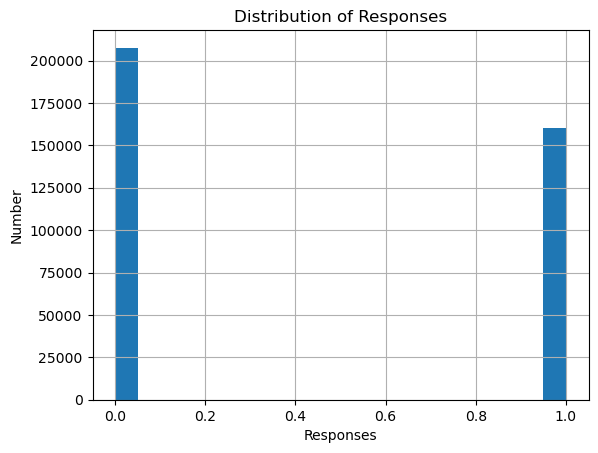

In [30]:
import matplotlib.pyplot as plt

# draw a histogram of the age column
(resc_data['correct']-1).hist(bins=20)

# add labels and title
plt.xlabel('Responses')
plt.ylabel('Number')
plt.title('Distribution of Responses')


In [31]:
plt.savefig('distribution_assist17.png')

<Figure size 640x480 with 0 Axes>

In [32]:
metadata = get_metadata(resc_data,["user_id", "item_id", "dimension_id"])

### Save data, concept map and metadata

In [33]:
# save selected data
resc_data.to_csv('../1-raw_data/assist17_selected_data.csv', index=False)

In [34]:
# Convert int64 keys to str
q2k_str_keys = {str(key): value for key, value in q2k.items()}

# Convert sets to lists in the dictionary
q2k_json_serializable = {}
for key, value in q2k_str_keys.items():
    if isinstance(value, set):
        q2k_json_serializable[key] = list(value)
    else:
        q2k_json_serializable[key] = value

# Save concept map
with open('concept_map.json', 'w') as f:
    json.dump(q2k_json_serializable, f)

In [35]:
# save metadata
with open('metadata.json', 'w') as f:
    json.dump(metadata, f)

## parse data

In [36]:
resc_data = pd.read_csv('../1-raw_data/assist17_selected_data.csv')
quadruplet = quadruplet_format(resc_data)

In [37]:
stu_data, ques_data = parse_data(resc_data)

In [38]:
test_size = 0.2
valid_size = 0.2 # proportion over the all dataset
least_test_length=100

## save row data

## vertical split

In [42]:
train_data, valid_data, test_data = split_data_vertically(quadruplet, test_prop=test_size,valid_prop=valid_size,folds_nb=5)

In [43]:
for i_fold, train_fold in enumerate(train_data):
    save_to_csv(train_data[i_fold], f'../2-preprocessed_data/assist17_train_quadruples_vert_{i_fold}.csv')
    save_to_csv(valid_data[i_fold], f'../2-preprocessed_data/assist17_valid_quadruples_vert_{i_fold}.csv')
    save_to_csv(test_data[i_fold], f'../2-preprocessed_data/assist17_test_quadruples_vert_{i_fold}.csv')